## Packages

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset 
from functools import partial

import transformers
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, BertConfig
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig, AdamW

import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, roc_curve, f1_score

/root/.virtualenvs/tradebot/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data


In [4]:
raw = pd.read_csv('tsla_dataset.csv', encoding='utf-8', names=['Date', 'News_Headline','label','score'])
raw['label'].replace({'neutral':'Neutral', 'positive':'Positive', 'negative': 'Negative'}, inplace=True)
raw = raw.drop(raw.index[0])
raw2 = raw.copy()
raw2['label'].replace({'Neutral':0, 'Positive':1, 'Negative':2}, inplace=True)
raw2 = raw2[['Date', 'News_Headline','label','score']]
seed = 2024

In [5]:
df_train, df_test, = train_test_split(raw2, stratify=raw2['label'], test_size=0.1, random_state=seed)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'], test_size=0.1, random_state=seed)
print(df_train.shape, df_test.shape, df_val.shape)

(7261, 4) (897, 4) (807, 4)


In [6]:
val_set = df_val.copy()
test_set = df_test.copy()
test_set = pd.concat([test_set, val_set], axis=0) # 把test和val concat起來
test_set.reset_index(inplace=True, drop = True)
test_set['label'].replace({0:'Neutral', 1:'Positive', 2:'Negative'}, inplace=True)
print(test_set.shape)

(1704, 4)


## Fine-tuned BERT Model

### I. Fine-tuning Process

In [7]:
bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
senti_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: senti_tokenizer(e['News_Headline'], truncation=True, padding='max_length', max_length=512), batched=True)
dataset_val = dataset_val.map(lambda e: senti_tokenizer(e['News_Headline'], truncation=True, padding='max_length', max_length=512), batched=True)
dataset_test = dataset_test.map(lambda e: senti_tokenizer(e['News_Headline'], truncation=True, padding='max_length' , max_length=512), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 897/897 [00:00<00:00, 5048.78 examples/s]


In [9]:
dataset_train

Dataset({
    features: ['Date', 'News_Headline', 'label', 'score', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7261
})

In [10]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'f1_score' : f1_score(predictions, labels, average='micro')}

args = TrainingArguments(
        output_dir='temp/',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_score',
)

trainer = Trainer(
        model=bert,                          # the instantiated Transformers model to be trained
        args=args,                           # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)


In [11]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Date, score, News_Headline, __index_level_0__. If Date, score, News_Headline, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/root/.virtualenvs/tradebot/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7261
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1135
  Number of trainable parameters = 109484547


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.157969,0.941760
2,No log,0.144693,0.960347
3,0.254600,0.179531,0.957869
4,0.254600,0.173600,0.960347
5,0.032100,0.185953,0.957869


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Date, score, News_Headline, __index_level_0__. If Date, score, News_Headline, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 807
  Batch size = 32
Saving model checkpoint to temp/checkpoint-227
Configuration saved in temp/checkpoint-227/config.json
Model weights saved in temp/checkpoint-227/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Date, score, News_Headline, __index_level_0__. If Date, score, News_Headline, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 807
  Batch size = 32
Saving model chec

TrainOutput(global_step=1135, training_loss=0.1277058274735438, metrics={'train_runtime': 839.9326, 'train_samples_per_second': 43.224, 'train_steps_per_second': 1.351, 'total_flos': 9552332630615040.0, 'train_loss': 0.1277058274735438, 'epoch': 5.0})

In [12]:
bert.eval()
trainer.predict(dataset_test).metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Date, score, News_Headline, __index_level_0__. If Date, score, News_Headline, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 897
  Batch size = 32


{'test_loss': 0.1704508513212204,
 'test_f1_score': 0.9431438127090301,
 'test_runtime': 7.0284,
 'test_samples_per_second': 127.625,
 'test_steps_per_second': 4.126}

In [13]:
trainer.save_model('BERT_fine_tuned_1')

Saving model checkpoint to BERT_fine_tuned_1
Configuration saved in BERT_fine_tuned_1/config.json
Model weights saved in BERT_fine_tuned_1/pytorch_model.bin


### II. Evaluate the Fine-tuned BERT Model

In [14]:
tuned_bert_model = BertForSequenceClassification.from_pretrained('BERT_fine_tuned_1', id2label={0: 'Neutral', 1: 'Positive', 2: 'Negative'})
senti_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

loading configuration file BERT_fine_tuned_1/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Neutral",
    "1": "Positive",
    "2": "Negative"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file BERT_fine_tune

In [15]:
tuned_bert_model.config.id2label

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [16]:
neutral = list()
positive = list()
negative = list()
for i in range(len(test_set)):
  inputs = senti_tokenizer(test_set.iloc[i, 0], padding=True, truncation=True, max_length=512, return_tensors='pt') #tokenize text to be sent to model
  outputs = tuned_bert_model(**inputs)
  predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
  neutral.append(predictions[0][0].tolist())
  positive.append(predictions[0][1].tolist())
  negative.append(predictions[0][2].tolist())

In [17]:
df_array = np.array(test_set)
df_list = list(df_array[:, 0])
table = {'News_Headline':df_list, "Positive":positive, "Negative":negative, "Neutral":neutral}      
result_ft_BERT = pd.DataFrame(table, columns = ["News_Headline", "Positive", "Negative", "Neutral"])
result_ft_BERT['Prediction'] = result_ft_BERT[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)
result_ft_BERT['label'] = test_set['label'].copy()
result_ft_BERT

,News_Headline,Positive,Negative,Neutral,Prediction,label
0,2017-08-04,0.005042,0.003893,0.991065,Neutral,Neutral
1,2020-02-27,0.005660,0.002780,0.991559,Neutral,Negative
2,2015-05-24,0.005497,0.002900,0.991603,Neutral,Neutral
3,2019-01-02,0.005876,0.002736,0.991388,Neutral,Negative
4,2019-09-13,0.004647,0.002629,0.992724,Neutral,Neutral
...,...,...,...,...,...,...
1699,2020-09-22,0.005415,0.002410,0.992175,Neutral,Positive
1700,2019-01-10,0.004631,0.002355,0.993013,Neutral,Neutral
1701,2020-11-17,0.005527,0.002463,0.992011,Neutral,Positive
1702,2017-05-11,0.006554,0.004327,0.989119,Neutral,Positive


In [18]:
print(classification_report(result_ft_BERT['label'], result_ft_BERT['Prediction']))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       357
     Neutral       0.60      1.00      0.75      1017
    Positive       0.00      0.00      0.00       330

    accuracy                           0.60      1704
   macro avg       0.20      0.33      0.25      1704
weighted avg       0.36      0.60      0.45      1704



/root/.virtualenvs/tradebot/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/.virtualenvs/tradebot/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/.virtualenvs/tradebot/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    :param confusion_matrix: numpy.ndarray, The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
                             Similarly, constructed nd.Arrays can also be used.
    :param class_names: An ordered list of class names, in the order they index the given confusion matrix.
    :param figsize: tuple, A 2-long tuple, the first value determining the horizontal size of the output figure, the second
                    determining the vertical size. Defaults to (10,7).
    :param fontsize: int, Font size for axes labels. Defaults to 14.
    :return: matplotlib.figure.Figure, The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

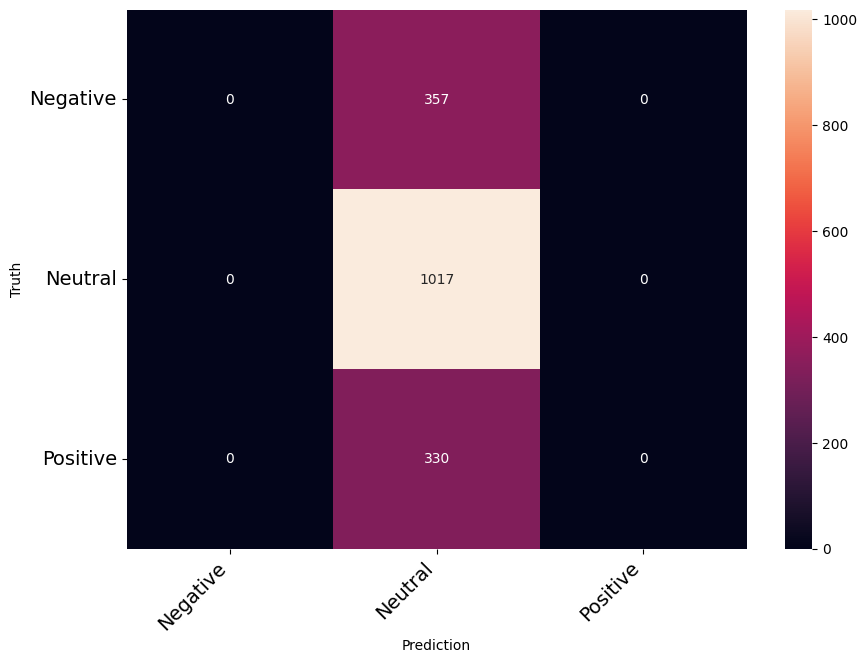

In [21]:
print_confusion_matrix(confusion_matrix(result_ft_BERT['label'], result_ft_BERT['Prediction']), ['Negative', 'Neutral', 'Positive'])

In [22]:
torch.cuda.empty_cache() # 這一步很重要